<a href="https://colab.research.google.com/github/finfrierson/data-science-fundamentals/blob/main/Fin_FrieU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

In [1]:
#Installations and grabbing my data
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz
!pip install bambi


import preliz as pz
import bambi as bmb
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-7isvaevr
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-7isvaevr
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=8e320b70455a654ae12622b14378b10627935cc03efd215b89d3ecd66fea9f4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-fen7prkd/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━

In [6]:
poke = pd.read_csv("https://raw.githubusercontent.com/finfrierson/data-science-fundamentals/refs/heads/main/pokemon_data_pokeapi%20-%20Sheet1.csv")


data set from https://www.kaggle.com/datasets/mohitbansal31s/pokemon-dataset

In [7]:
poke

,Name,Pokedex Number,Type1,Type2,Classification,Height,Weight,Abilities,Generation,Legendary Status
0,Bulbasaur,1,Grass,Poison,Seed Pokémon,0.7,6.9,"Overgrow, Chlorophyll",1,No
1,Ivysaur,2,Grass,Poison,Seed Pokémon,1.0,13.0,"Overgrow, Chlorophyll",1,No
2,Venusaur,3,Grass,Poison,Seed Pokémon,2.0,100.0,"Overgrow, Chlorophyll",1,No
3,Charmander,4,Fire,NaN,Lizard Pokémon,0.6,8.5,"Blaze, Solar-power",1,No
4,Charmeleon,5,Fire,NaN,Flame Pokémon,1.1,19.0,"Blaze, Solar-power",1,No
...,...,...,...,...,...,...,...,...,...,...
900,Ursaluna,901,Ground,Normal,でいたんポケモン,2.4,290.0,"Guts, Bulletproof, Unnerve",8,No
901,Basculegion-male,902,Water,Ghost,おおうおポケモン,3.0,110.0,"Swift-swim, Adaptability, Mold-breaker",8,No
902,Sneasler,903,Fighting,Poison,クライミングポケモン,1.3,43.0,"Pressure, Unburden, Poison-touch",8,No
903,Overqwil,904,Dark,Poison,けんざんポケモン,2.5,60.5,"Poison-point, Swift-swim, Intimidate",8,No


My data set contains information on a large number of pokemon, incliuding descriptors such as their types, weight in kilograms, height in meters, moves, and more. For many animals, an increasing height almost always garuntees a larger weight, so I wanted to see if a similar trend occured with pokemon.

In [4]:
for num in range(905):
  if poke["Weight"][num]>400:
    poke=poke.drop(num)
  elif poke["Height"][num]>4:
    poke=poke.drop(num)

I had some outliers with extroardinary height and/or weight, making my model run awkwardly, so I decided to drop a few data points (around 25 were dropped), even at the cost of a little model accurac. It also makes my data more presentable.

Text(0, 0.5, 'Weight')

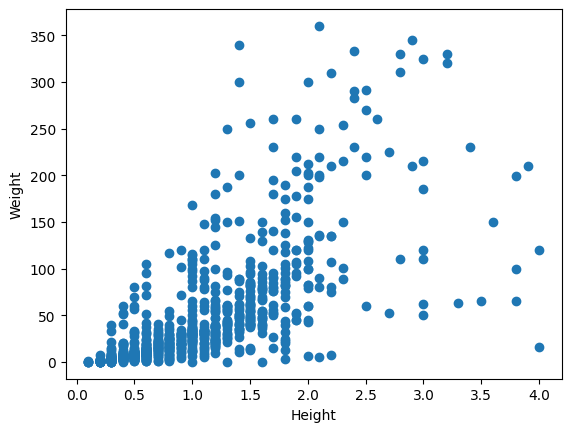

In [ ]:
plt.scatter(poke['Height'],poke["Weight"])

plt.xlabel("Height")
plt.ylabel("Weight")

From this plot between height in metres and weight in kilograms (one kilogram is roughly 2.2 pounds) I can see an initial pretty standard positive correlation between the two variables, but after around 2 meters high the amount of data points drops off, so i struggle to find a relationship. This is why I sdecided to use a GP, as it cand find the relatioons between points and create a well informed model, whereas something like a B spline would have set intervals for its data, and thus potentially incur problems with the lower data points past 2 meters in height.

Before this data set and model I had tried around 2 to 3 other data sets in which I could not find strong relationships in, and had tried GPs and B splines. This model that I have ended up creating here was the best of my results, but I was already low on time when I got to here.

#Model

Pretty standard model comparing height to weight.

In [ ]:
#Getting weight and height values
Weight = poke["Weight"].values
Height = poke["Height"].values[:,None]
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
  #Generates "a weakly informative prior for the length-scale parameter of the GP kernel."

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
#Finishing modeling
with pm.Model() as model_hsgp:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(Height))

    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    f = gp.prior('f', X=Height)
    α = pm.HalfNormal('α', 1)

    y = pm.NegativeBinomial("y", np.exp(f), α, observed=Weight)


    idata_hsgp = pm.sample()

Output()

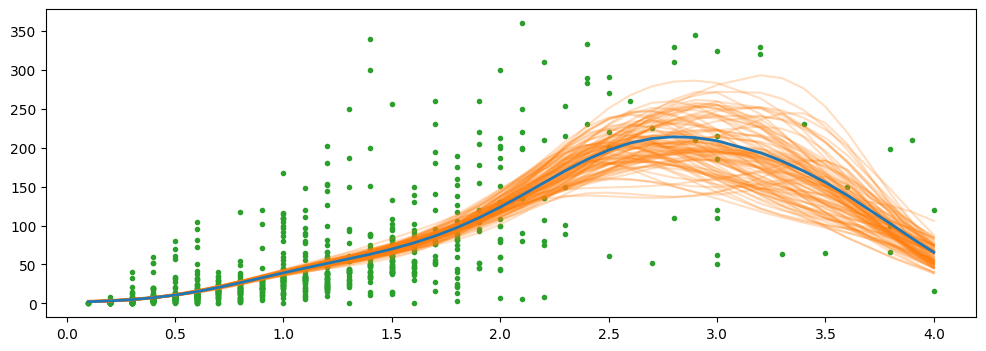

In [ ]:
#Plotting results from the model with height on the X Axis and weight on the Y ais
_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(poke["Height"].values, poke["Weight"].values, "C2.")

f = az.extract(idata_hsgp, group="posterior", var_names="f")

idx = np.argsort(poke["Height"].values)
ax.plot(poke["Height"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
ax.plot(poke["Height"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

#Conclusion

There are a few things worth note to takeaway from this model. Firstly, the initial positive correlation I noticed was correct, and the model was extremely confident of this. Second, the model becomes far more unsure around 3 m in height, as there is far more variation in the predicted lines. Lastly, there ended up being a negative correlation between the two variables past 3 m in height, but as there is little data there, I cannot be sure of this being accurate.